In [1]:
import writefile_run as writefile_run

In [2]:
filename = '../../anomaly_detectors/som_knn_detector/som_knn_wrapper.py'

In [3]:
%%writefile_run $filename

import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import pickle

#torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#importing sklearn libraries
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os


# Importing reader and checker python files as modules
from anomaly_detectors.reader_writer import db_properties as db_props
from anomaly_detectors.reader_writer import writer_configs as write_args

import psycopg2

from anomaly_detectors.utils.preprocessors import *
from anomaly_detectors.utils.data_handler import *
# from anomaly_detectors.bayesian_detectorbayesian_changept_detector import *

from anomaly_detectors.utils import error_codes as error_codes
from anomaly_detectors.utils import type_checker as type_checker
from anomaly_detectors.utils import csv_prep_for_reader as csv_helper
from anomaly_detectors.utils import reader_helper
from anomaly_detectors.utils import make_ackg_json


from anomaly_detectors.som_knn_detector import som_knn_detector as som_detector
from anomaly_detectors.som_knn_detector import som_knn_module as som_model


import json
import traceback


import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

In [4]:
import pylab as pl
from IPython import display 

In [5]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

# Learning

In [6]:
%%writefile_run $filename -a



ideal_train_kwargs_type  = {
            'som_shape':tuple,
            'input_feature_size':int,
            'time_constant':float,
            'minNumPerBmu':int,
            'no_of_neighbors':int,
            'initial_radius':float,
            'initial_learning_rate':float,
            'n_iterations':int,
            'N':int,    
            'diff_order':int,
            'is_train':bool,
            'epochs':int,
            'batch_size':int,
            'to_plot':bool,
            'test_frac':float
        }

ideal_eval_kwargs_type = {
            'model_path':str,
            'to_plot':bool,
            'anom_thres':int
        }

mode_options = ['DETECT','LOG','DETECT_LOG']

In [7]:
%%writefile_run $filename -a


def train(json_data,mode=mode_options[2],network_shape=None,input_feature_size=None,time_constant=None,minNumPerBmu=2,
          no_of_neighbours=10,init_radius=None,init_learning_rate=0.01,N=100,diff_order=1,is_train=True
          ,epochs=4,batch_size=4,to_plot=True,test_frac=0.5):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in reader args and parses json 
                            and gives dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        It takes reader args as of now to get the dataset and algo related arguments
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        
        
        #algorithm arguments

        model_input_args = {
            'som_shape':network_shape,
            'input_feature_size':None,
            'time_constant':None,
            'minNumPerBmu':minNumPerBmu,
            'no_of_neighbors':no_of_neighbours,
            'initial_radius':init_radius,
            'initial_learning_rate':init_learning_rate,
            'n_iterations':None,
            'N':N,    
            'diff_order':diff_order
        }
        
        #Training arguments
        training_args = {
            'is_train':True,
            'epochs':epochs,
            'batch_size':batch_size,
            'to_plot':to_plot,
            'test_frac':test_frac
        }
        
        
        
        #merging all algo arguments for params checking
        algo_kwargs = {**model_input_args,**training_args}
        
                    
        try: 
            '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
            '''
            
            error_codes.reset()
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=ideal_train_kwargs_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return res
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = pd.unique(data_per_asset['assetno'])[0]
#                     print(assetno)
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]]
                                                                 )
                    
                    
                    print("Data of Asset no: {} \n {}\n".format(assetno,data_per_asset.head()))
                    cols = list(data_per_asset.columns[1:])
                    
                    anomaly_detector = som_detector.Som_Detector(data = data_per_asset,                                                            assetno=assetno,model_input_args=model_input_args,
                                                                 training_args=training_args,metric_names=cols,
                                                                eval_args=None)
                    
                    table_name = write_args.table_name
                    window_size = 10
                    anom_indexes = anomaly_detector.detect_anomalies()
                    anomaly_detectors.append(anomaly_detector)
                    sql_query_args = write_args.writer_kwargs
                        

                
                out_json = {}
                
                if(mode==mode_options[0] or mode==mode_options[2]):
                    ack_json = make_ackg_json.make_ack_json(anomaly_detectors)
                    out_json['ack_json'] = ack_json
                if(mode==mode_options[1] or mode==mode_options[2]):
                    '''
                    Instantiates writer class to write into local database with arguments given below
                    Used for Bulk writing
                    '''
                    writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,
                                             sql_query_args=sql_query_args,
                                            table_name=table_name,window_size=window_size)

                    #called for mapping args before writing into db
                    res = writer.map_outputs_and_write()
                    out_json['log_json']=res
               
                return json.dumps(out_json)
                
                
            else:
                '''
                Data empty error
                '''
                return json.dumps(error_codes.error_codes['data_missing'])
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes.error_codes['unknown']['message']=e
            return json.dumps(error_codes.error_codes['unknown'])

In [8]:
%%writefile_run $filename -a


def evaluate(json_data,model_path,mode=mode_options[2],to_plot=True,anom_thres=3):

    
        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in reader args and parses json 
                            and gives dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        It takes reader args as of now to get the dataset and algo related arguments
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        
        eval_args = {
            'model_path':model_path,
            'to_plot':to_plot,
            'anom_thres':anom_thres
        }
                
                    
        try: 
            '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
            '''
            
            error_codes.reset()
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=eval_args,ideal_args_type=ideal_eval_kwargs_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return res
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(json_data=json_data)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = pd.unique(data_per_asset['assetno'])[0]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]]
                                                                 )
                    
                    print("Data of Asset no: {} \n {}\n".format(assetno,data_per_asset.head()))
                    cols = list(data_per_asset.columns[1:])
                    
                    anomaly_detector = som_detector.Som_Detector(data = data_per_asset,                                                            assetno=assetno,model_input_args=model_input_args,
                                                                 training_args=None,metric_names=cols,eval_args=eval_args)
                    
                    anom_indexes = anomaly_detector.detect_anomalies()
                    anomaly_detectors.append(anomaly_detector)
                    
                out_json = {}
                
                if(mode==mode_options[0] or mode==mode_options[2]):
                    ack_json = make_ackg_json.make_ack_json(anomaly_detectors)
                    out_json['ack_json'] = ack_json
                if(mode==mode_options[1] or mode==mode_options[2]):
                    
                    '''
                    Instantiates writer class to write into local database with arguments given below
                    Used for Bulk writing
                    '''
                    sql_query_args = write_args.writer_kwargs
                    table_name = write_args.table_name
                    window_size = 10

                    writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                            table_name=table_name,window_size=window_size)

                    #called for mapping args before writing into db
                    res = writer.map_outputs_and_write()
                    out_json['log_json'] = res
                    
                return json.dumps(out_json)
                
                
            else:
                '''
                Data empty error
                '''
                return error_codes.error_codes['data_missing']
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes.error_codes['unknown']['message']=e
            return error_codes.error_codes['unknown']

# Arguments

In [9]:
%%writefile_run $filename -a


reader_kwargs= lambda:{
            'assetno':['1'],
            'from_timestamp':'',
            'to_timestamp':'',
            'con':'',
            'para_list':'',
            'source_type':'',
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
}

model_input_args = lambda :{
    'network_shape':(8,8),
    'input_feature_size':None,
    'time_constant':None,
    'minNumPerBmu':2,
    'no_of_neighbours':3,
    'init_radius':0.4,
    'init_learning_rate':0.01,
    'N':100,    
    'diff_order':1
}

training_args = lambda:{
            'is_train':True,
            'epochs':5,
            'batch_size':4,
            'to_plot':True,
            'test_frac':0.7
        }


        
eval_args = lambda: {
    'model_path':'',
    'to_plot':True,
    'anom_thres':3
}

In [10]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['TSFAD_A1']
con = '192.168.2.5:4242'
src_type =  'opentsdb'
param = ['ec2_cpu_utilization_5f5533']
from_timestamp = 1392388020
to_timestamp = 1393597320

## Training on data from opentsdb and saving it in a model

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  ec2_cpu_utilization_5f5533
timestamp                                          
1392388020000  TSFAD_A1                    2.029859
1392388320000  TSFAD_A1                    0.324761
1392388620000  TSFAD_A1                   -0.433681
1392388920000  TSFAD_A1                    1.268165
1392389220000  TSFAD_A1                    0.837359

Shape of the Entire dataset : torch.Size([4032, 1])

torch.float64
Shape of Training dataset :torch.Size([3226, 1]) and Test dataset :torch.Size([807, 1])

Dataset has 3226 rows 1 columns


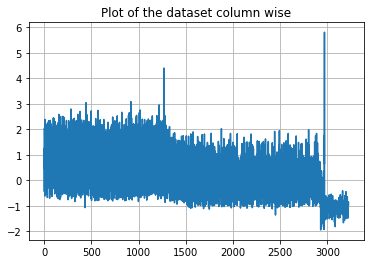

Network dimensions are 8 x 7 


Shape of differenced Training data : (3226, 1)

Epoch : 0 completed 
 Max Bmu index : (0, 0)
Epoch : 1 completed 
 Max Bmu index : (0, 0)
Epoch : 2 completed 
 Max Bmu index : (0, 0)
Epoch : 3 completed 
 Max Bmu index : (0, 0)
Epoch : 4 completed 
 Max Bmu index : (0, 0)

 Training successfully completed 


Saved model : som_trained_model_ec2cpuutilization5f5533_1530043550539 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1530043550539

Input data's shape: (4032, 1)
Differenced data shape (4032, 1)
(4032,)


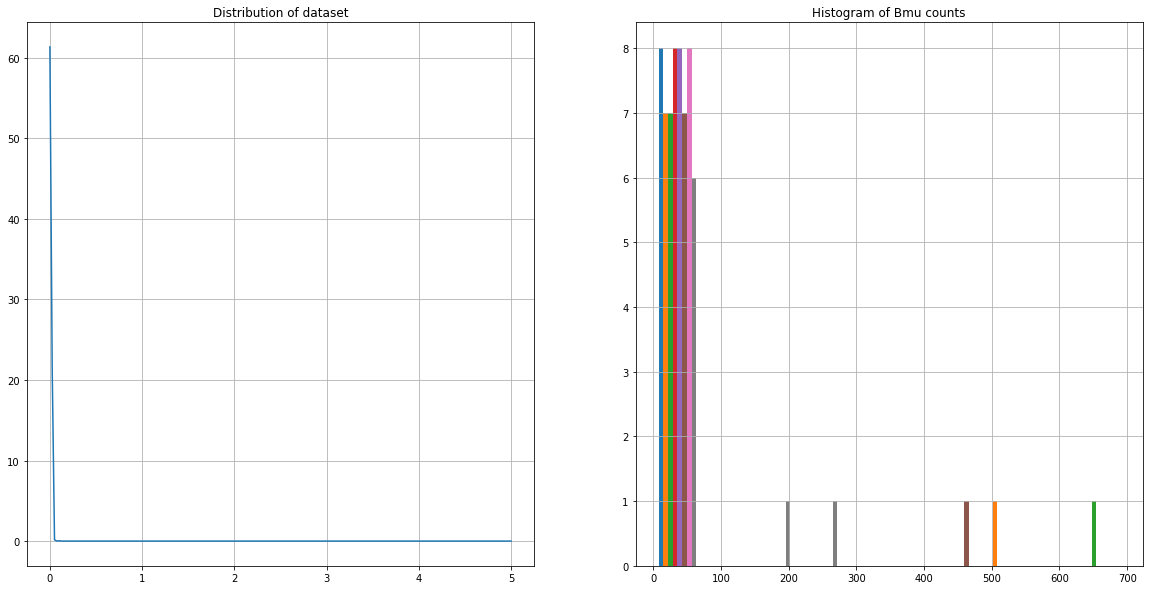

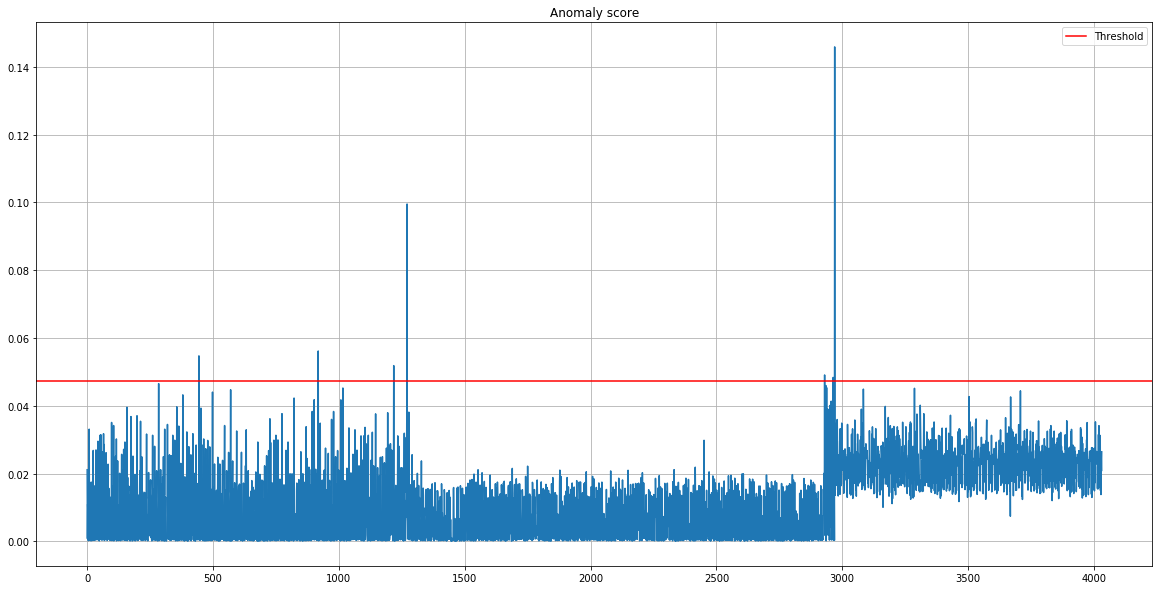

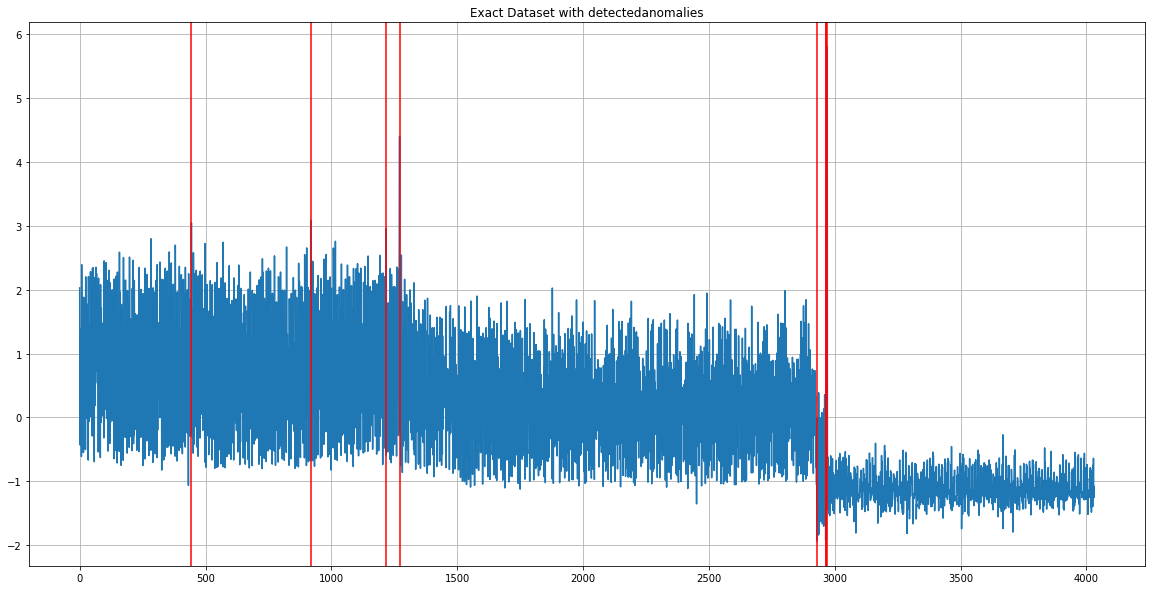

No of anomalies detected : 8, Fraction of data detected as anomaly : 0.001984126984126984
{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "ec2_cpu_utilization_5f5533", "datapoints": [[1392521220000, 1392521220000], [1392663420000, 1392663420000], [1392753420000, 1392753420000], [1392769320000, 1392769320000], [1393267020000, 1393267020000], [1393277220000, 1393277220000], [1393278120000, 1393278120000], [1393279020000, 1393279020000]]}]}]}}


In [11]:
# %%writefile_run som_knn_wrapper_sprint1.py -a


'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints and writing
to database
'''

reader_kwargs1 = reader_kwargs()
reader_kwargs1['assetno'] = assetno
reader_kwargs1['source_type']=src_type
reader_kwargs1['con'] = con
reader_kwargs1['from_timestamp'] = from_timestamp
reader_kwargs1['to_timestamp'] = to_timestamp
reader_kwargs1['para_list'] = param
model_input_args1 = model_input_args()
training_args1 = training_args()
training_args1['test_frac'] = 0.2
json_data = reader_helper.read(reader_kwargs=reader_kwargs1)
model_input_args1['diff_order'] = 0
kwargs1 = {**model_input_args1,**training_args1}
res = train(**kwargs1,json_data=json_data,mode=mode_options[0])

print(res)

## Testing saved model on data from opentsdb

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: TSFAD_A1 
                 assetno  ec2_cpu_utilization_5f5533
timestamp                                          
1392388020000  TSFAD_A1                    2.029859
1392388320000  TSFAD_A1                    0.324761
1392388620000  TSFAD_A1                   -0.433681
1392388920000  TSFAD_A1                    1.268165
1392389220000  TSFAD_A1                    0.837359

Shape of the Entire dataset : torch.Size([4032, 1])

Input data's shape: (4032, 1)
Differenced data shape (4032, 1)
(4032,)


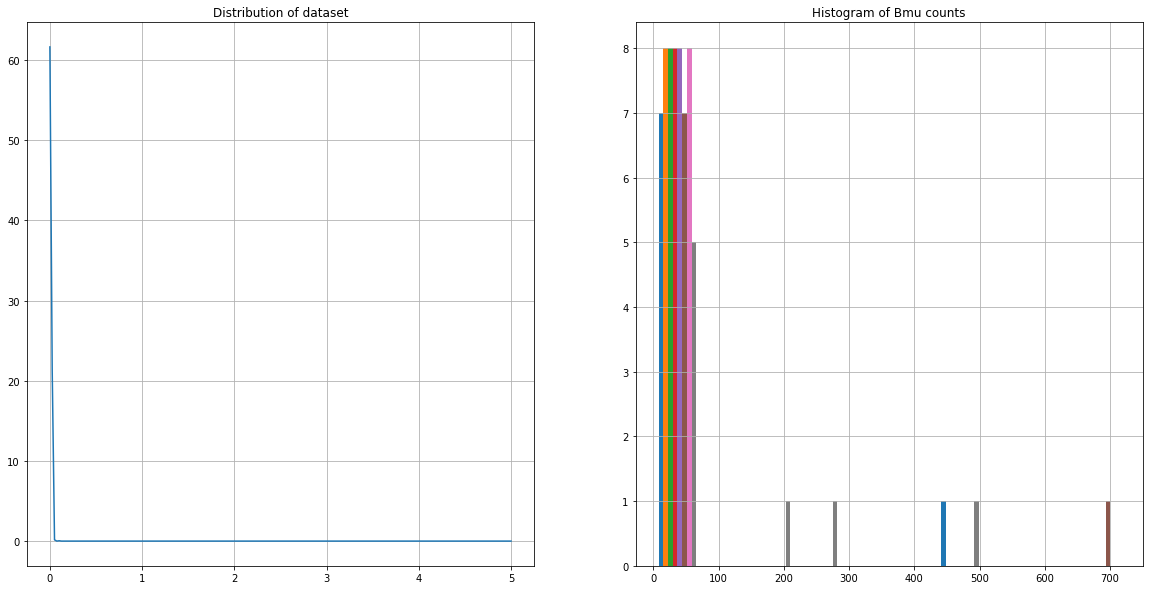

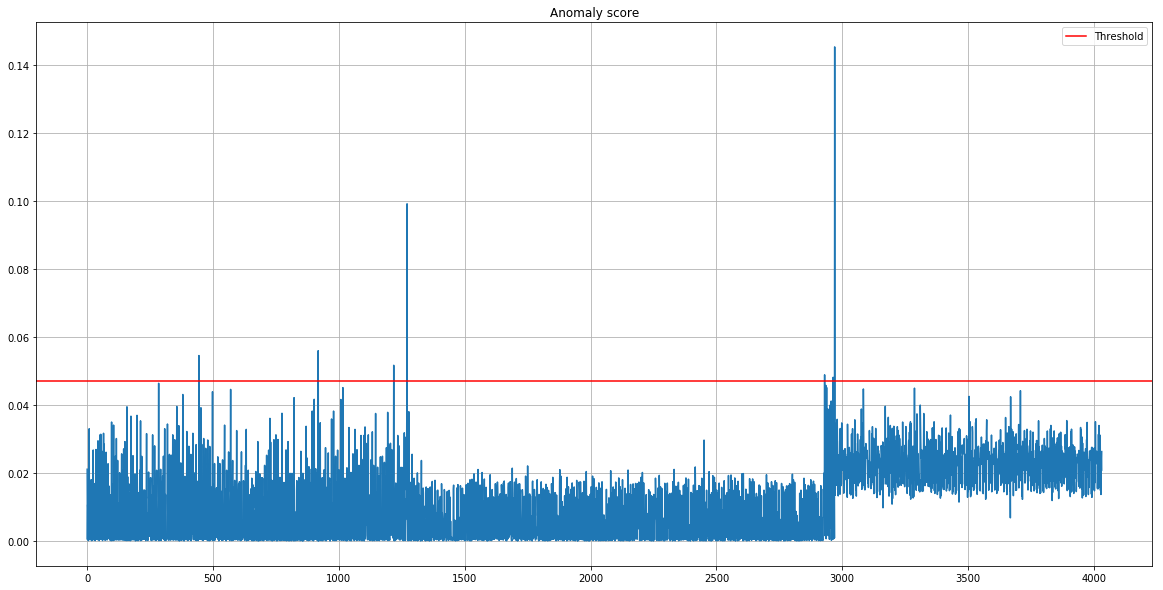

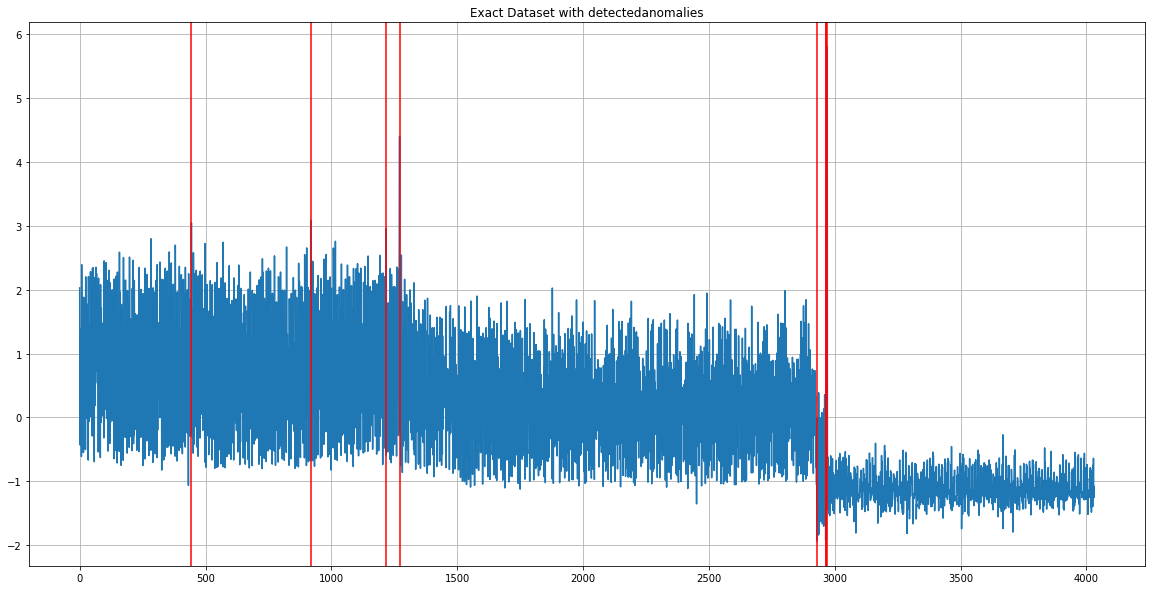

No of anomalies detected : 8, Fraction of data detected as anomaly : 0.001984126984126984

 No of Anomalies detected = 8
{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": "TSFAD_A1", "anomalies": [{"name": "ec2_cpu_utilization_5f5533", "datapoints": [[1392521220000, 1392521220000], [1392663420000, 1392663420000], [1392753420000, 1392753420000], [1392769320000, 1392769320000], [1393267020000, 1393267020000], [1393277220000, 1393277220000], [1393278120000, 1393278120000], [1393279020000, 1393279020000]]}]}]}}


In [12]:
'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints with 
a trained model and writing anomalies to database
'''

reader_kwargs1 = reader_kwargs()
reader_kwargs1['assetno'] = assetno
reader_kwargs1['con'] = con
reader_kwargs1['source_type']=src_type
reader_kwargs1['from_timestamp'] = from_timestamp
reader_kwargs1['to_timestamp'] = to_timestamp
reader_kwargs1['para_list'] = param
eval_args1 = eval_args()
eval_args1['anom_thres'] = 3
eval_args1['model_path'] = '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_ec2cpuutilization5f5533_1530042946720'
json_data = reader_helper.read(reader_kwargs1)
res = evaluate(**eval_args1,json_data=json_data,mode=mode_options[0])
print(res)

## Training on data from a list of sample csv datasets and saving them in a model

In [13]:
data_dir = '../../dataset/sample_csv_files/'
target_dir = '../../dataset/reader_csv_files/'
assetno = ['1']
difforders = [1,0,0,2,2,1]

for i,filename in enumerate(os.listdir(data_dir)):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    
    kwargs1 = csv_helper.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    
#     print('params: {}\n'.format(param))
    reader_kwargs1 = kwargs1
    model_input_args1 = model_input_args()
    model_input_args1['diff_order'] = difforders[i]
    training_args1 = training_args()
    training_args1['to_plot'] = False
    json_data = reader_helper.read(reader_kwargs1)
    
    kwargs1 = {**model_input_args1,**training_args1}
    res = train(**kwargs1,json_data=json_data)
    print(res)


Detecting anomalies for alcohol-demand-log-spirits-consu.csv

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1.0 
                assetno  \
timestamp                
-3.147898e+12      1.0   
-3.137357e+12      1.0   
-3.126816e+12      1.0   
-3.116362e+12      1.0   
-3.105821e+12      1.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                           0.026580                 
-3.137357e+12                                           0.114869                 
-3.126816e+12                                           0.247302                 
-3.116362e+12                                           0.379735                 
-3.105821e+12                                           0.423880                 

Shape of the Entire dataset : torch.Size([207, 1])

torch.float64
Shape of Training data


 Training successfully completed 


Saved model : som_trained_model_MonthlyUSfemale20yearsandoverunemploymentfigures10319481981_1530043555173 in ../../Anomaly_Detection_Models/Machine_Learning_Models,
Last Checkpointed at: 1530043555173

Input data's shape: (408, 1)
Differenced data shape (406, 1)
(406,)
No of anomalies detected : 4, Fraction of data detected as anomaly : 0.00980392156862745
Postgres writer initialised 


Multivariate writer initialised

 Successfully written into database

{"ack_json": {"header": {"code": "200", "status": "OK"}, "body": [{"asset": 1.0, "anomalies": [{"name": "Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981", "datapoints": [[152496000000.0, 152496000000.0], [155088000000.0, 155088000000.0], [373420800000.0, 373420800000.0], [376012800000.0, 376012800000.0]]}]}]}, "log_json": {"code": "200", "status": "OK"}}

Detecting anomalies for winter-negative-temperature-sum-.csv

Data reader initialised 

Getting the dataset from t

## Testing the saved model on sample csv datasets

In [16]:
infile = '../../dataset/sample_csv_files/alcohol-demand-log-spirits-consu.csv'
filename = 'alcohol-demand-log-spirits-consu.csv'
target_dir = '../../dataset/reader_csv_files/'
assetno = ['1']
kwargs1 = csv_helper.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])
    
reader_kwargs1 = kwargs1
eval_args1 = eval_args()
eval_args1['to_plot'] = False
eval_args1['model_path'] = '../../Anomaly_Detection_Models/Machine_Learning_Models/som_trained_model_AlcoholdemandlogspiritsconsumptionperheadUK18701938_1530043108564'
kwargs1 = {**eval_args1}
json_data = reader_helper.read(reader_kwargs1)
res = evaluate(**kwargs1,json_data=json_data)
print(res)

Data reader initialised 

Getting the dataset from the reader....

Data of Asset no: 1.0 
                assetno  \
timestamp                
-3.147898e+12      1.0   
-3.137357e+12      1.0   
-3.126816e+12      1.0   
-3.116362e+12      1.0   
-3.105821e+12      1.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                           0.026580                 
-3.137357e+12                                           0.114869                 
-3.126816e+12                                           0.247302                 
-3.116362e+12                                           0.379735                 
-3.105821e+12                                           0.423880                 

Shape of the Entire dataset : torch.Size([207, 1])

Input data's shape: (207, 1)
Differenced data shape (206, 1)
(206,)
No of anomalies detected : 4, F

## Performance or Algorithm Tuning Test:

model_input_args = lambda :{
    'network_shape':(8,8),
    'input_feature_size':None,
    'time_constant':None,
    'minNumPerBmu':2,
    'no_of_neighbours':3,
    'init_radius':0.4,
    'init_learning_rate':0.01,
    'N':100,    
    'diff_order':1
}

training_args = lambda:{
            'is_train':True,
            'epochs':5,
            'batch_size':4,
            'to_plot':True,
            'test_frac':0.7
        }

data_dir = 'dataset/one_csv/'
target_dir = 'dataset/reader_csv_files/'
assetno = ['1']
difforders = [1,0,0,2,2,1]

model_input_args1 = model_input_args()
training_args1 = training_args()

init_radiuses = [0.01,0.025,0.05,0.1,0.25,0.5,1,1.5]
no_neighbors = [2,4,6,8,10,12,14,16,20,25]
init_learning_rates = [0.0001,0.001,0.01,0.05,0.1,0.25,0.5]
minPerBmus = [1,2,4,6,8,10,12]


for i,filename in enumerate(os.listdir(data_dir)):
    for rad in init_radiuses:
        for no_neighbor in no_neighbors:
            for minPerBmu in minPerBmus:
                for init_learning_rate in init_learning_rates:
                    model_input_args1['init_learning_rate'] = init_learning_rate
                    model_input_args1['minNumPerBmu'] = minPerBmu
                    model_input_args1['no_of_neighbours'] = no_neighbor
                    model_input_args1['init_radius'] = rad
                    
                    print("\nModel args :Learnrate : {},minbmu:{},neighbors:{},init_Rad:{}\n".format(init_learning_rate,
                                                                                                    minPerBmu,no_neighbor,rad))
                    name,ext = os.path.splitext(filename)
                    if ext != '.csv':continue
                    infile = os.path.join(data_dir,filename)
                    print("\nDetecting anomalies for {}\n".format(filename))


                    kwargs1 = csv_reader.get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0])

                #     print('params: {}\n'.format(param))
                    reader_kwargs1 = kwargs1
                    model_input_args1 = model_input_args()
                    model_input_args1['diff_order'] = 0
                    training_args1 = training_args()
                    kwargs1 = {**reader_kwargs1,**model_input_args1,**training_args1}
                    res = main(**kwargs1,anom_thres=2.5)
                    print(res)